* Setup and load data

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
import tensorflow as tf
import keras
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.merge import concatenate
from keras.layers import UpSampling2D, Conv2D, Activation, Input, Dropout, MaxPooling2D
from keras import Model
from keras import backend as K
from keras.layers.core import Lambda
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input
/kaggle/input/severstal-steel-defect-detection
/kaggle/input/severstal-steel-defect-detection/train_images
/kaggle/input/severstal-steel-defect-detection/test_images


In [0]:
train_df = pd.read_csv("/kaggle/input/severstal-steel-defect-detection/train.csv")

In [0]:
n_typ = 4
n_img = train_df.shape[0]/n_typ
train_df["ImageId"] = train_df["ImageId_ClassId"].apply(lambda x: x.split('_')[0])
train_df["ClassId"] = train_df["ImageId_ClassId"].apply(lambda x: x.split('_')[1])
train_df["IsDefect"] = train_df["EncodedPixels"].notnull()

In [0]:
n_total = 200
n_valid = 100
df = train_df.iloc[2::4,:]
df_defect = df[df["IsDefect"]==True][:n_total]
df_defect.reset_index(inplace=True,drop=True)
print(df_defect.head(5))
df_valid = df[df["IsDefect"]==True][n_total:n_total+n_valid]
df_valid.reset_index(inplace=True,drop=True)



   ImageId_ClassId                                      EncodedPixels  \
0  0007a71bf.jpg_3  18661 28 18863 82 19091 110 19347 110 19603 11...   
1  0014fce06.jpg_3  229501 11 229741 33 229981 55 230221 77 230468...   
2  0025bde0c.jpg_3  8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...   
3  0046839bd.jpg_3  152926 1 153180 4 153434 6 153689 8 153943 11 ...   
4  005d86c25.jpg_3  331 18 587 53 843 89 1099 124 1355 159 1611 17...   

         ImageId ClassId  IsDefect  
0  0007a71bf.jpg       3      True  
1  0014fce06.jpg       3      True  
2  0025bde0c.jpg       3      True  
3  0046839bd.jpg       3      True  
4  005d86c25.jpg       3      True  


* U-Net Model 

In [0]:
np.random.seed(1234)
tf.random.set_seed(1234)
dropout = 0.1
def create_model():
    inputs = Input((256, 1600, 3))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s) 
    c1 = Dropout(dropout) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(dropout) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(dropout) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(dropout) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(dropout) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(dropout) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(dropout) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(dropout) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(dropout) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])    
    
    return model

* Setup callbacks and create model

In [0]:
def exp_decay(epoch):
    initial_lrate = 0.0015
    k = 0.0005
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)


reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=3, min_lr=0.0001)

checkpoint_path = 'cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback =  tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 verbose=1,
                                                 save_weights_only=True,
                                                 period=1) #  save weights for everry  epoch


opt = keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, amsgrad=False)

model = create_model()
model.compile(optimizer=opt, loss='binary_crossentropy')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 1600, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 16 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 1600, 16 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

* Define utility functions

In [0]:
def rle2mask(rle, imgshape=(256,1600)):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [0]:
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos+1)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [0]:
def keras_generator(batch_size,df):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):            
            #print(i)
            fn = df['ImageId_ClassId'].iloc[i].split('_')[0]
            #print(fn)
            img = cv2.imread( '/kaggle/input/severstal-steel-defect-detection/train_images/'+fn )
            #print("before resize",img.shape)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            
            mask = rle2mask(df['EncodedPixels'].iloc[i], img.shape)
            
            #img = cv2.resize(img, (img_size, img_size))
            #mask = cv2.resize(mask, (img_size, img_size))
            #print("after resize",img.shape)            
            x_batch += [img]
            y_batch += [mask]
                                    
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [0]:
for x, y in keras_generator(2,df_defect):
    break
    
print(x.shape, y.shape)

(2, 256, 1600, 3) (2, 256, 1600, 1)


* Fit

In [0]:
batch_size = 16
results = model.fit_generator(keras_generator(batch_size,df_defect), 
                              steps_per_epoch=int(df_defect.shape[0]/batch_size),
                              epochs=10,
                              verbose=1,
                              callbacks=[cp_callback,reduce_lr],
                              validation_data = keras_generator(batch_size,df_valid),
                              validation_steps=int(df_valid.shape[0]/batch_size)
                            ) 
model.save('my_steel_model.h5')

Epoch 1/10
12/12 [==============================] - 18s 1s/step - loss: 0.4403 - val_loss: 0.4156

Epoch 00001: saving model to cp-0001.ckpt
Epoch 2/10
12/12 [==============================] - 9s 717ms/step - loss: 0.3576 - val_loss: 0.3225

Epoch 00002: saving model to cp-0002.ckpt
Epoch 3/10
12/12 [==============================] - 9s 718ms/step - loss: 0.3043 - val_loss: 0.2663

Epoch 00003: saving model to cp-0003.ckpt
Epoch 4/10
12/12 [==============================] - 9s 717ms/step - loss: 0.2722 - val_loss: 0.2838

Epoch 00004: saving model to cp-0004.ckpt
Epoch 5/10
12/12 [==============================] - 9s 715ms/step - loss: 0.2617 - val_loss: 0.2451

Epoch 00005: saving model to cp-0005.ckpt
Epoch 6/10
12/12 [==============================] - 8s 661ms/step - loss: 0.2454 - val_loss: 0.2363

Epoch 00006: saving model to cp-0006.ckpt
Epoch 7/10
12/12 [==============================] - 8s 684ms/step - loss: 0.1815 - val_loss: 0.1985

Epoch 00007: saving model to cp-0007.ckpt
E

10


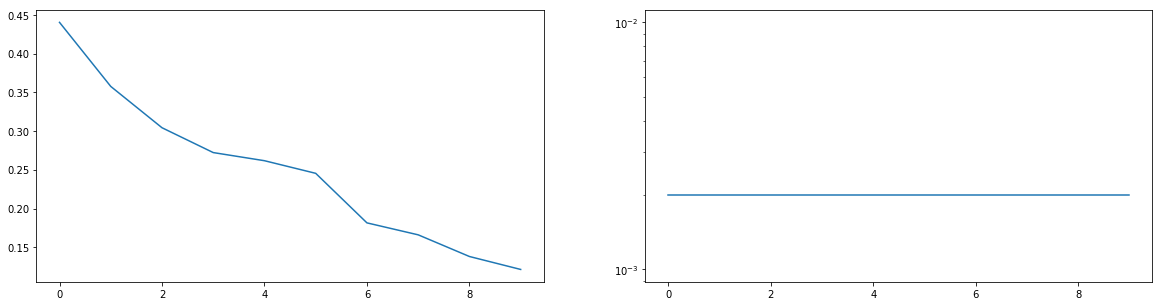

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
plt.yscale('log')
axes[0].plot(results.history['loss'])
axes[1].plot(results.history['lr'])
#print(results.history['loss'])
best_epoch = results.history['loss'].index(min(results.history['loss']))+1
print(best_epoch)
#print(results.history['lr'])


* Find threshold value that yields best score

In [0]:
model.load_weights('cp-{:04d}.ckpt'.format(best_epoch))
img_path = '/kaggle/input/severstal-steel-defect-detection/train_images/'
n_valid = 10
thresh = 0.12

def iou_metric(y_true_in, y_pred_in, print_table=False):
    y_pred_in = y_pred_in>thresh
    intersect = y_true_in * y_pred_in
    union = y_true_in + y_pred_in
    #fig, axes = plt.subplots(1, 4, figsize=(50, 200))
    #img = cv2.imread(img_path + img_name)
    #axes[0].imshow(y_true_in)
    #axes[1].imshow(y_pred_in)
    #axes[2].imshow(intersect)    
    #axes[3].imshow(union)    
    union[union>1]=1
    iou = intersect.sum()/union.sum()
    #plt.plot(union)
    #plt.show()
    return iou
        
def evaluate(df, thresh):  
    t1=[]
    for i in range(n_valid):
        img_name = df['ImageId'].iloc[i]
        timg = cv2.imread( img_path + img_name)
        timg = cv2.cvtColor(timg, cv2.COLOR_BGR2RGB)
        t1 += [timg]
    t1 = np.array(t1)
    pred = model.predict(t1)
    ious = []
    for i in range(n_valid):  
        pred[i][pred[i]>thresh] = 1
        img_name = df['ImageId'].iloc[i]
        truemask = rle2mask(df['EncodedPixels'].iloc[i])
        img = cv2.imread(img_path + img_name)
        iou = iou_metric(truemask,np.squeeze(pred[i]))
#        if(i<1):
#            fig, axes = plt.subplots(1, 3, figsize=(20, 60))
#            axes[0].imshow(img/255)
#            axes[1].imshow(np.squeeze(truemask))
#            axes[2].imshow(np.squeeze(pred[i]))
#            axes[0].set_title(df['ImageId'].iloc[i])
#            axes[1].set_title('True mask')
#            axes[2].set_title('Predicted mask, thresh= {},iou = {}'.format(thresh,iou))
#            plt.show()
        ious.append(iou)
    #print(ious)
    return(np.mean(ious))
    
threshs = np.linspace(0.05,0.95,10)
mean_ious = []
for thresh in threshs:
    #print(thresh)
    mean_iou = evaluate(df_defect,thresh)
    mean_ious.append(mean_iou)


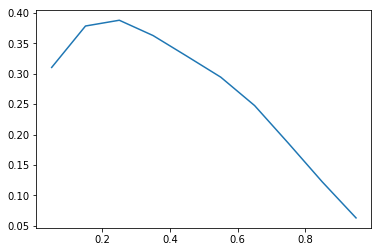

best mean_ious = 0.388, at thresholding = 0.250


In [0]:
plt.plot(threshs,mean_ious)
plt.show()
print("best mean_ious = {:.3f}".format(max(mean_ious)), end=', at ')
print("thresholding = {:.3f}".format(threshs[mean_ious.index(max(mean_ious))]))